# Imports

In [1]:
# import libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams

# Stats
import statsmodels.tsa.stattools as sts 
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats.distributions import chi2
from math import exp
from scipy.stats import norm
from scipy import stats
import statsmodels.api as sm
rcParams['figure.figsize'] = 12, 7
%matplotlib inline

# Date
import datetime as datetime

# Mapping
import geopandas as gpd
import geoplot
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 8, 6
from shapely.geometry import Polygon
import libpysal as lp
import rasterio as rio
import numpy as np
import contextily as ctx
from matplotlib import colors
import shapely.geometry as geom
# from shapely.geometry import Point

# Regression
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import time
import pyarrow
from matplotlib.pylab import rcParams
from dask.distributed import Client, progress, LocalCluster
import statsmodels.api as sm

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace import sarimax

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,  plot_pacf

# import libraries from SARIMA project
import pandas as pd
from scipy import stats
from scipy.stats import norm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import statsmodels.tsa.stattools as sts 
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats.distributions import chi2
from datetime import timedelta
rcParams['figure.figsize'] = 12, 7
%matplotlib inline

# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse


## Import NYC Parking Violation Data

In [2]:
prec_df = pd.read_csv('ParkingTickets_200414.csv')
prec_df.head()

,Unnamed: 0,Plate,time_issued,Fine_Amount,Amount_Due,Payment_Amount,precinct,State,Bronx,Brooklyn,Manhattan,Queens,Staten_Island,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,258,JPF1565,2019-12-31 11:16:00,45.0,0.0,0.0,61.0,1,0,1,0,0,0,0,1,0,0,0,0,0
1,322,HZG4714,2019-12-31 08:10:00,45.0,0.0,0.0,46.0,1,1,0,0,0,0,0,1,0,0,0,0,0
2,359,HYH2149,2019-12-30 11:11:00,45.0,0.0,0.0,75.0,1,0,1,0,0,0,1,0,0,0,0,0,0
3,368,FGD8792,2019-12-30 09:03:00,45.0,0.0,0.0,88.0,1,0,1,0,0,0,1,0,0,0,0,0,0
4,369,HGM5765,2019-12-30 08:59:00,45.0,0.0,0.0,88.0,1,0,1,0,0,0,1,0,0,0,0,0,0


In [3]:
prec_df.shape

(5000970, 20)

## Additional Feature Engineering

In [4]:
prec_df['time_issued']=pd.to_datetime(prec_df['time_issued'], errors='coerce')
prec_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000970 entries, 0 to 5000969
Data columns (total 20 columns):
Unnamed: 0        int64
Plate             object
time_issued       datetime64[ns]
Fine_Amount       float64
Amount_Due        float64
Payment_Amount    float64
precinct          float64
State             int64
Bronx             int64
Brooklyn          int64
Manhattan         int64
Queens            int64
Staten_Island     int64
weekday_0         int64
weekday_1         int64
weekday_2         int64
weekday_3         int64
weekday_4         int64
weekday_5         int64
weekday_6         int64
dtypes: datetime64[ns](1), float64(4), int64(14), object(1)
memory usage: 763.1+ MB


In [5]:
prec_df['time_issued'] = prec_df['time_issued'].dt.round('H')

In [6]:
chart = prec_df.groupby(["precinct"]).agg({'Fine_Amount':'count'})
# chart['precinct'] = chart['precinct'].astype('str')
chart.isna().sum()

Fine_Amount    0
dtype: int64

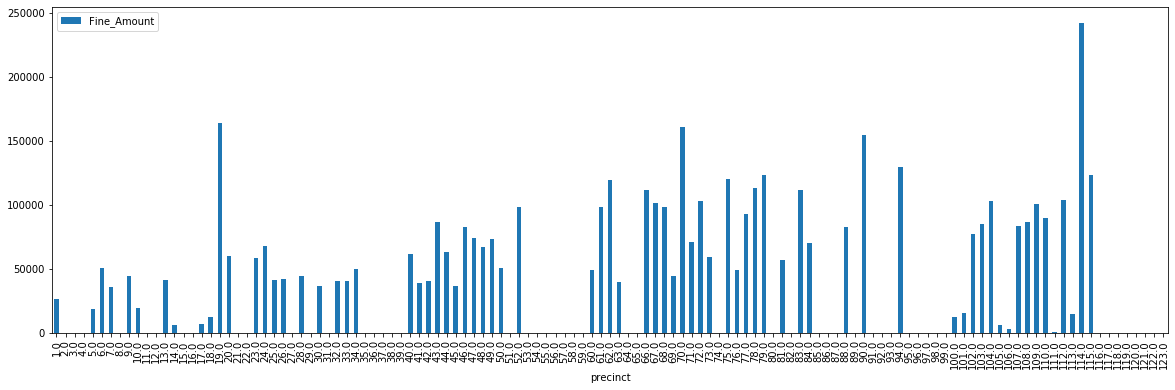

In [7]:
chart.plot(kind='bar',figsize=(20,6))

In [8]:
chart.tail(10)

,Fine_Amount
precinct,
114.0,242229
115.0,123051
116.0,55
117.0,43
118.0,15
119.0,25
120.0,45
121.0,28
122.0,79


In [9]:
# test=prec_df.loc(prec_df['precinct']==1)

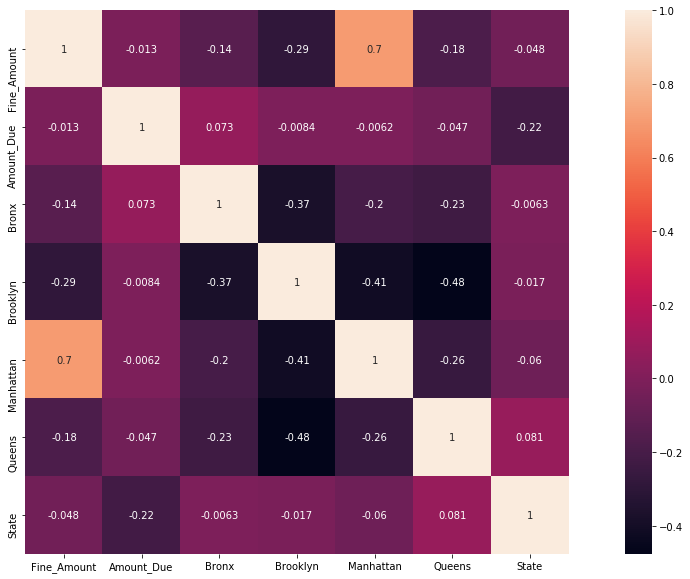

In [10]:
# sns.heatmap

corrmat = prec_df[['Fine_Amount','Amount_Due',\
              'Bronx', 'Brooklyn', 'Manhattan', 'Queens','State'\
             ]].corr()
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrmat,square=True,annot=True)

In [11]:
borough = prec_df.groupby(["Manhattan"]).agg({'Fine_Amount':'sum','Amount_Due':'sum','Payment_Amount':'sum'})
borough.head()

,Fine_Amount,Amount_Due,Payment_Amount
Manhattan,,,
0,183925058.0,4.027247e+07,4.027247e+07
1,51479810.0,8.577056e+06,8.577056e+06


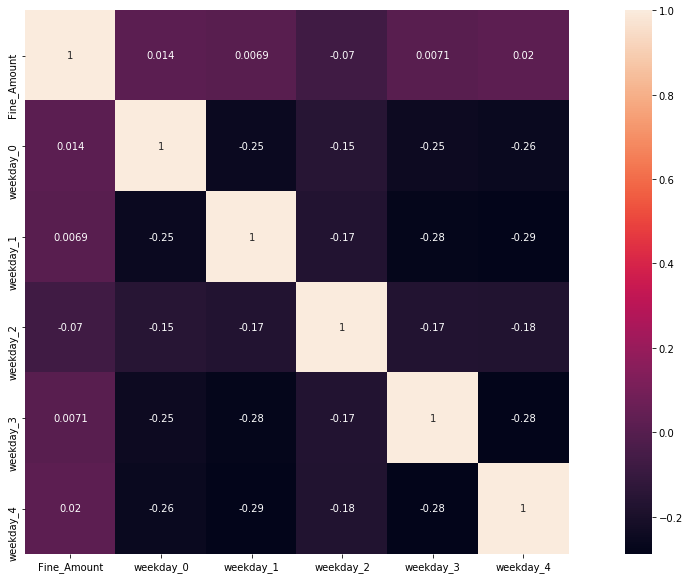

In [12]:
# sns.heatmap

corrmat = prec_df[['Fine_Amount',\
              'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4'\
             ]].corr()
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrmat,square=True,annot=True)

findfont: Font family ['calibri'] not found. Falling back to DejaVu Sans.
findfont: Font family ['calibri'] not found. Falling back to DejaVu Sans.


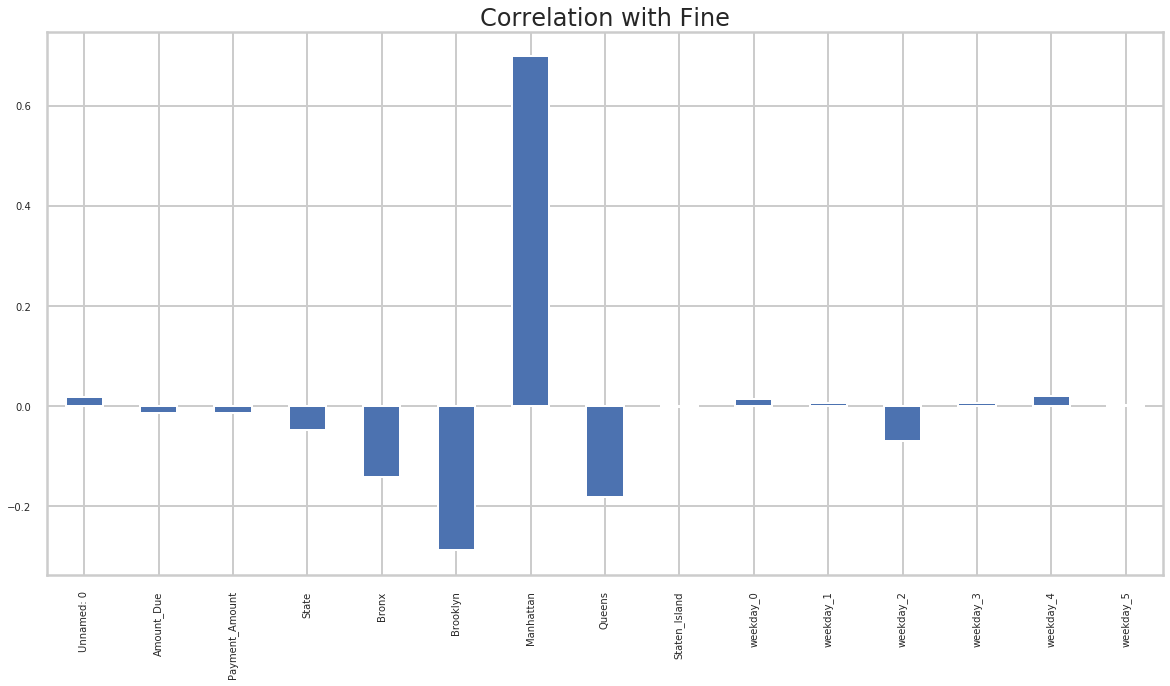

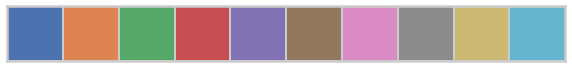

In [13]:
X = prec_df.drop(['Fine_Amount','precinct','weekday_6'],axis=1)
y = prec_df['Fine_Amount']

sns.set(style="whitegrid", palette=("deep"),font='calibri')
sns.set_context("poster")

X.corrwith(prec_df['Fine_Amount']).plot.bar(figsize = (20, 10), title ="Correlation with Fine", fontsize = 10,
rot = 90, grid = True,)

sns.palplot(sns.color_palette())

## Integrate Geopspatial Data (shp)

In [14]:
districts = gpd.read_file('Shape_Files/geo_export_49baef8e-ad00-4dbc-869a-5cd2bd3bc4d6.shp')
districts.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 4 columns):
precinct      77 non-null float64
shape_area    77 non-null float64
shape_leng    77 non-null float64
geometry      77 non-null geometry
dtypes: float64(3), geometry(1)
memory usage: 2.5 KB


In [15]:
map_df = prec_df.copy()

In [16]:
map_df = map_df.set_index(map_df['time_issued'])

In [17]:
map_df.columns

Index(['Unnamed: 0', 'Plate', 'time_issued', 'Fine_Amount', 'Amount_Due',
       'Payment_Amount', 'precinct', 'State', 'Bronx', 'Brooklyn', 'Manhattan',
       'Queens', 'Staten_Island', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6'],
      dtype='object')

In [18]:
map_df.drop(columns =['Unnamed: 0', 'Plate',
       'Payment_Amount', 'State', 'Bronx', 'Brooklyn', 'Manhattan',
       'Queens', 'Staten_Island'], inplace=True)

In [19]:
map_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5000970 entries, 2019-12-31 11:00:00 to 2017-01-05 12:00:00
Data columns (total 11 columns):
time_issued    datetime64[ns]
Fine_Amount    float64
Amount_Due     float64
precinct       float64
weekday_0      int64
weekday_1      int64
weekday_2      int64
weekday_3      int64
weekday_4      int64
weekday_5      int64
weekday_6      int64
dtypes: datetime64[ns](1), float64(3), int64(7)
memory usage: 457.9 MB


In [20]:
map_df.shape

(5000970, 11)

In [21]:
# precinct_dummies = pd.get_dummies(prec_df['precinct'], prefix='precinct')
# prec_df = pd.concat([prec_df, precinct_dummies], axis=1)

In [22]:
# map_df.loc[map_df['time_issued']=2017-11-24, 'time_issued']= np.nan 

map_df.loc['2017-11-24']=np.nan
map_df.loc['2018-11-23']=np.nan
map_df.loc['2019-11-29']=np.nan
map_df.dropna(inplace = True)
map_df.shape

(4937633, 11)

In [23]:
map_df = map_df.groupby(["precinct"]).agg({'weekday_0':'sum','weekday_1':'sum','weekday_2':'sum',\
                                           'weekday_3':'sum','weekday_4':'sum','weekday_5':'sum','weekday_6':'sum'})
map_df.head()

,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
precinct,,,,,,,
1.0,5264.0,6248.0,709.0,6034.0,6506.0,1316.0,16.0
2.0,22.0,21.0,6.0,16.0,21.0,7.0,0.0
3.0,12.0,14.0,1.0,8.0,16.0,3.0,0.0
4.0,16.0,17.0,6.0,11.0,6.0,4.0,0.0
5.0,2757.0,2269.0,2198.0,3880.0,4406.0,3196.0,9.0


In [24]:
map_df2 = map_df.merge(districts, how='left', on='precinct', copy=False)
map_df2.head()
map_df.shape

(123, 7)

In [25]:
map_df2.drop(columns =['shape_area', 'shape_leng'], inplace=True)

In [26]:
# Coordinate reference system based on NYC maps
crs = {'init': 'epsg:2263'}

map_gdf = gpd.GeoDataFrame(map_df2, crs=crs, geometry=map_df2['geometry'])
map_gdf.head()

,precinct,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,geometry
0,1.0,5264.0,6248.0,709.0,6034.0,6506.0,1316.0,16.0,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ..."
1,2.0,22.0,21.0,6.0,16.0,21.0,7.0,0.0,None
2,3.0,12.0,14.0,1.0,8.0,16.0,3.0,0.0,None
3,4.0,16.0,17.0,6.0,11.0,6.0,4.0,0.0,None
4,5.0,2757.0,2269.0,2198.0,3880.0,4406.0,3196.0,9.0,"POLYGON ((-73.98864 40.72293, -73.98869 40.722..."


In [27]:
map_gdf.weekday_0.describe()

count      123.000000
mean      7442.658537
std       9003.939270
min          0.000000
25%          8.000000
50%       4328.000000
75%      13490.000000
max      47994.000000
Name: weekday_0, dtype: float64

In [28]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

### Monday

In [29]:
vmin, vmax = 0, 25000

findfont: Font family ['calibri'] not found. Falling back to DejaVu Sans.


Text(0.5, 1, 'Monday')

findfont: Font family ['calibri'] not found. Falling back to DejaVu Sans.
findfont: Font family ['calibri'] not found. Falling back to DejaVu Sans.


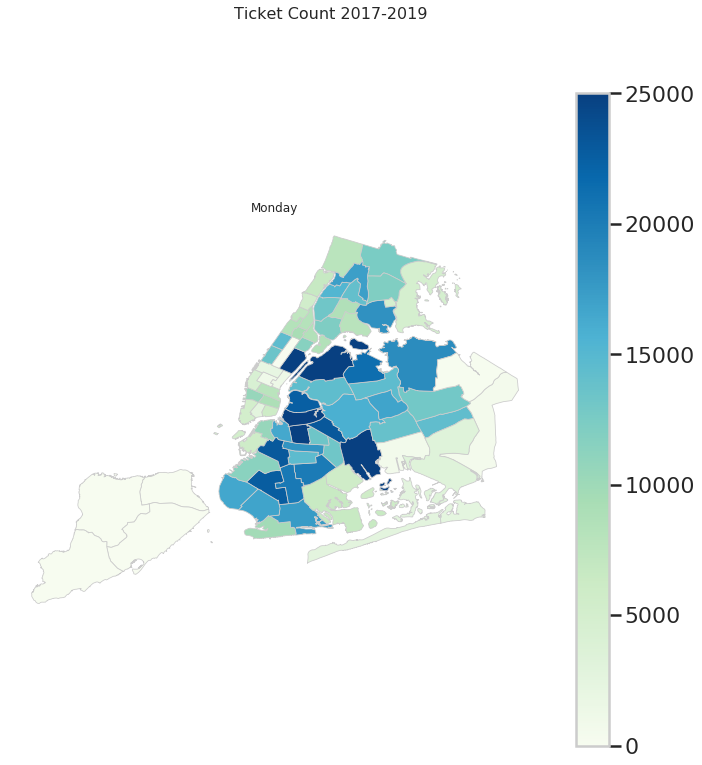

In [30]:
Monday = map_gdf.plot(column='weekday_0', cmap='GnBu', figsize=(12,12), linewidth=0.8, edgecolor='0.8', 
                       legend=True, norm=plt.Normalize(vmin=vmin, vmax=vmax))

Monday.axis('off')

plt.suptitle('Ticket Count 2017-2019', fontsize=16)
plt.title('Monday', fontsize=12)

### Tuesday

Text(0.5, 1, 'Tuesday')

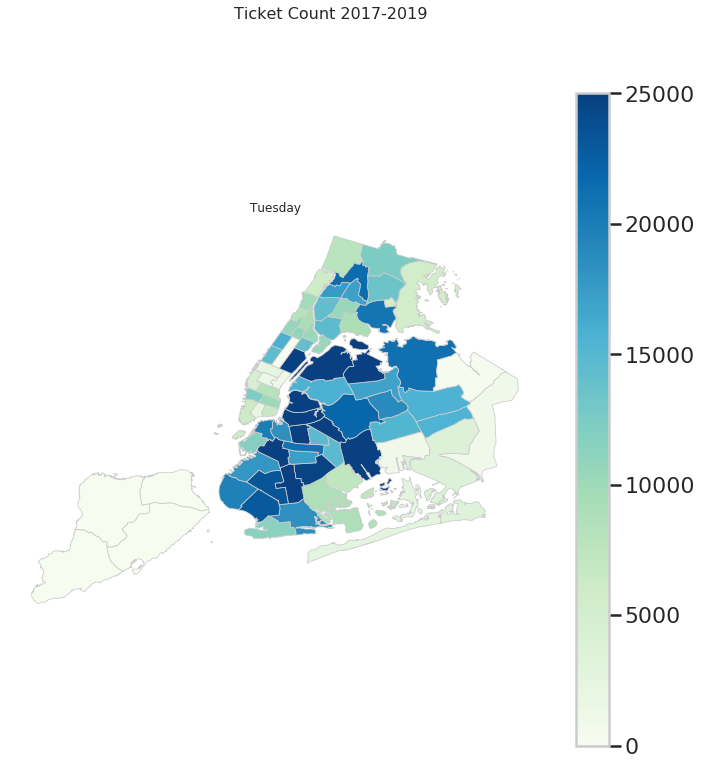

In [31]:
Tuesday = map_gdf.plot(column='weekday_1', cmap='GnBu', figsize=(12,12), linewidth=0.8, edgecolor='0.8', 
                       legend=True, norm=plt.Normalize(vmin=vmin, vmax=vmax))

Tuesday.axis('off')

plt.suptitle('Ticket Count 2017-2019', fontsize=16)
plt.title('Tuesday', fontsize=12)

### Wednesday

Text(0.5, 1, 'Wednesday')

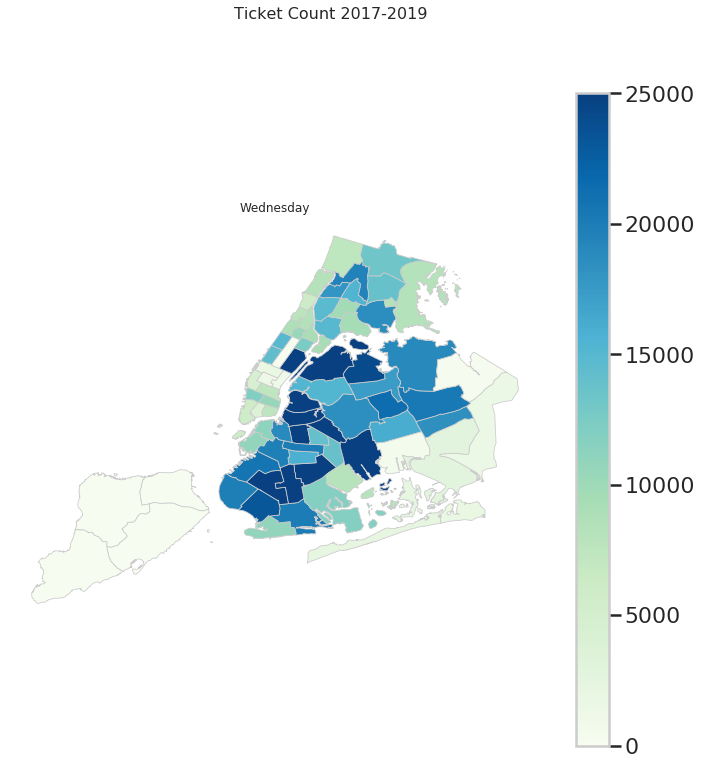

In [32]:
Wednesday = map_gdf.plot(column='weekday_3', cmap='GnBu', figsize=(12,12), linewidth=0.8, edgecolor='0.8', 
                       legend=True, norm=plt.Normalize(vmin=vmin, vmax=vmax))

Wednesday.axis('off')

plt.suptitle('Ticket Count 2017-2019', fontsize=16)
plt.title('Wednesday', fontsize=12)

### Thursday

Text(0.5, 1, 'Thursday')

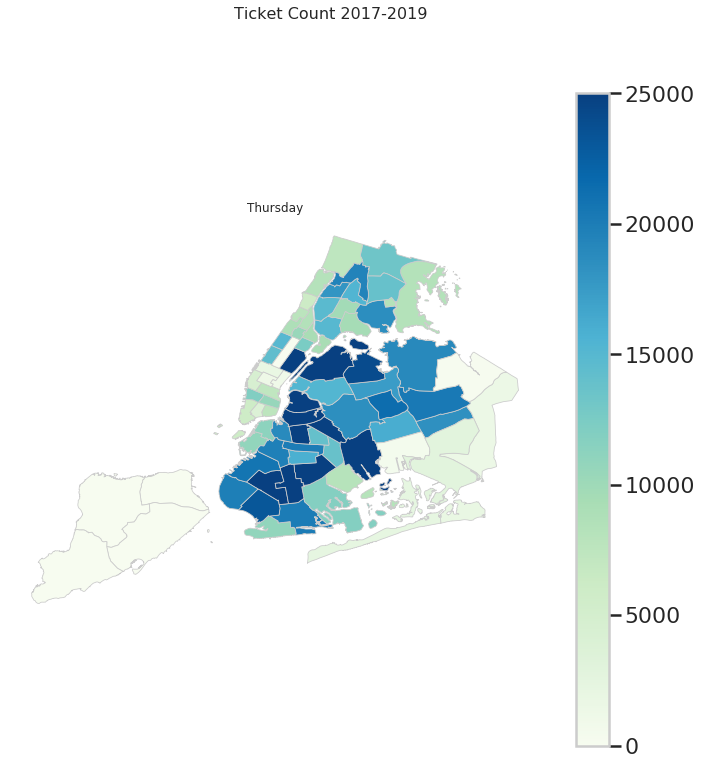

In [33]:
Thursday = map_gdf.plot(column='weekday_3', cmap='GnBu', figsize=(12,12), linewidth=0.8, edgecolor='0.8', 
                       legend=True, norm=plt.Normalize(vmin=vmin, vmax=vmax))

Thursday.axis('off')

plt.suptitle('Ticket Count 2017-2019', fontsize=16)
plt.title('Thursday', fontsize=12)

### Friday

Text(0.5, 1, 'Friday')

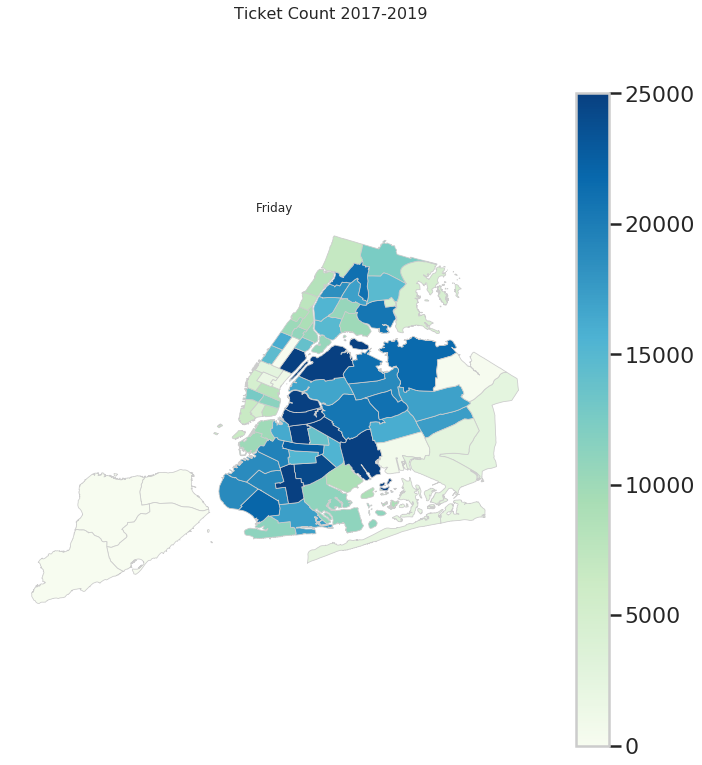

In [34]:
Friday = map_gdf.plot(column='weekday_4', cmap='GnBu', figsize=(12,12), linewidth=0.8, edgecolor='0.8', 
                       legend=True, norm=plt.Normalize(vmin=vmin, vmax=vmax))

Friday.axis('off')

plt.suptitle('Ticket Count 2017-2019', fontsize=16)
plt.title('Friday', fontsize=12)

In [35]:
# fig, ax = plt.subplots(figsize=(12,10), subplot_kw=dict(aspect='equal'))    
# plt.title('Amount Due by Precinct, 2016-2019')
# ax.set_axis_off()
# plt.legend(loc='center left', bbox_to_anchor=(1.1, .5), fontsize='xx-small', frameon=False)
# map_gdf.plot(column='Amount_Due', edgecolor='black',\
#                 scheme='Quantiles', \
#                 k=5, cmap='GnBu', legend=True, ax=ax)

# Timeseries EDA

In [36]:
timeseries_df = prec_df.copy()

In [37]:
timeseries_df.head()

,Unnamed: 0,Plate,time_issued,Fine_Amount,Amount_Due,Payment_Amount,precinct,State,Bronx,Brooklyn,Manhattan,Queens,Staten_Island,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,258,JPF1565,2019-12-31 11:00:00,45.0,0.0,0.0,61.0,1,0,1,0,0,0,0,1,0,0,0,0,0
1,322,HZG4714,2019-12-31 08:00:00,45.0,0.0,0.0,46.0,1,1,0,0,0,0,0,1,0,0,0,0,0
2,359,HYH2149,2019-12-30 11:00:00,45.0,0.0,0.0,75.0,1,0,1,0,0,0,1,0,0,0,0,0,0
3,368,FGD8792,2019-12-30 09:00:00,45.0,0.0,0.0,88.0,1,0,1,0,0,0,1,0,0,0,0,0,0
4,369,HGM5765,2019-12-30 09:00:00,45.0,0.0,0.0,88.0,1,0,1,0,0,0,1,0,0,0,0,0,0


In [38]:
import holidays

us_holidays = holidays.UnitedStates()
def is_holiday(day):
    if day in us_holidays:
        return True
    else:
        return False

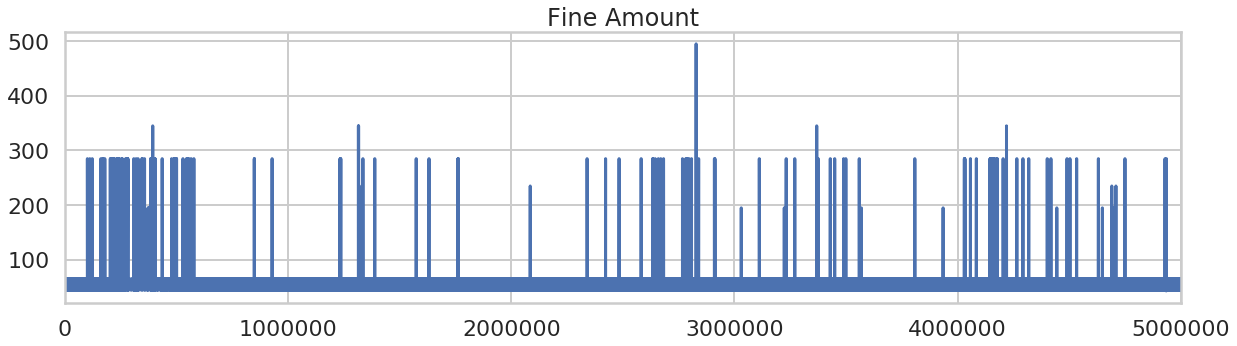

In [39]:
timeseries_df.Fine_Amount.plot(figsize = (20,5))
plt.title("Fine Amount", size= 24)
plt.show()

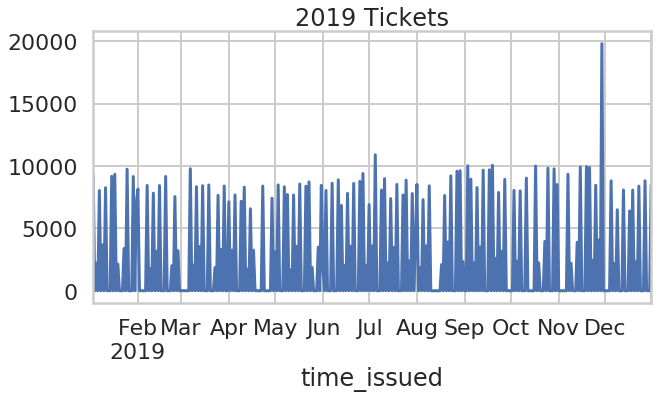

In [40]:
timeseries_df[(timeseries_df['time_issued'].dt.year == 2019) & (timeseries_df['time_issued'].dt.day)]\
.groupby(['time_issued'])['Fine_Amount'].count().resample('d').sum().plot(kind='line',figsize = (10,5))
plt.title("2019 Tickets", size= 24)
plt.show()

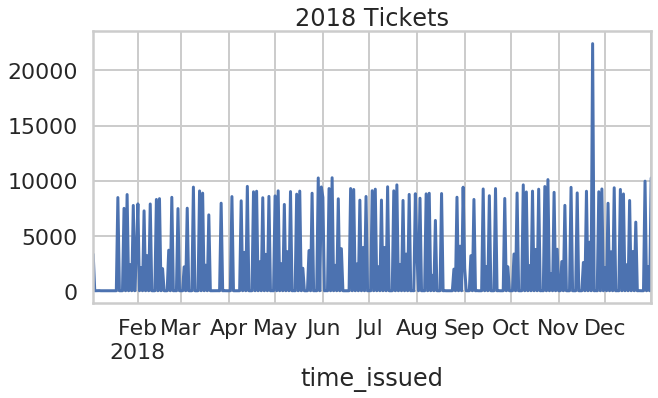

In [41]:
timeseries_df[(timeseries_df['time_issued'].dt.year == 2018) & (timeseries_df['time_issued'].dt.day)]\
.groupby(['time_issued'])['Fine_Amount'].count().resample('d').sum().plot(figsize = (10,5))
plt.title("2018 Tickets", size= 24)
plt.show()

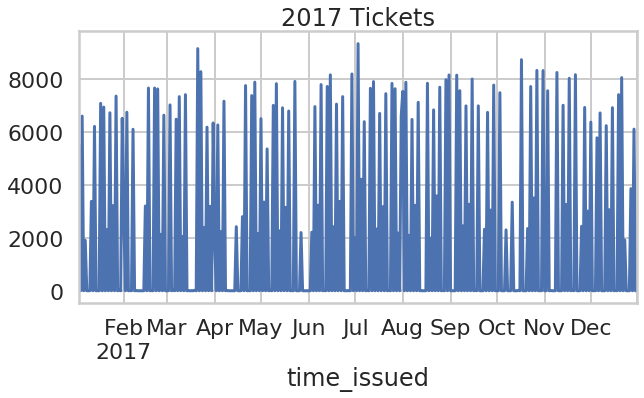

In [42]:
timeseries_df[(timeseries_df['time_issued'].dt.year == 2017) & (timeseries_df['time_issued'].dt.day)]\
.groupby(['time_issued'])['Fine_Amount'].count().resample('d').sum().plot(figsize = (10,5))
plt.title("2017 Tickets", size= 24)
plt.show()

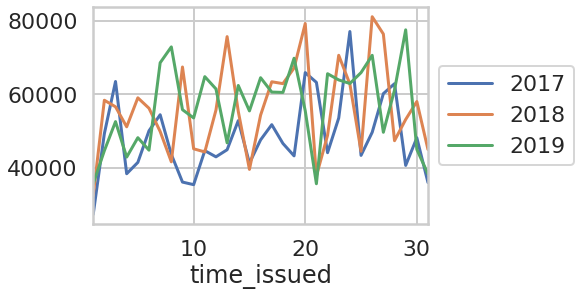

In [43]:
(timeseries_df.groupby([timeseries_df['time_issued'].dt.day,\
                       timeseries_df['time_issued'].dt.year])\
 ['Fine_Amount'].count()).unstack().plot(kind='line')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

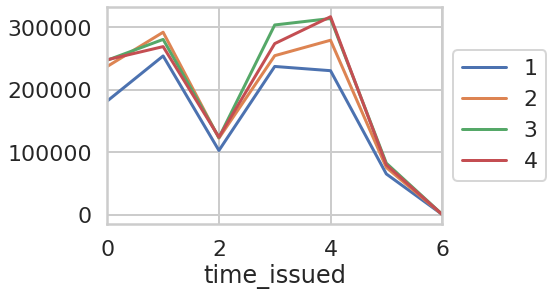

In [126]:
(timeseries_df.groupby([timeseries_df['time_issued'].dt.weekday,\
                       timeseries_df['time_issued'].dt.quarter])\
 ['Fine_Amount'].count()).unstack().plot(kind='line')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

## Drop Days

### Black Friday
Need to remove this anomoly to smooth the data

In [44]:
timeseries_df = timeseries_df.set_index(timeseries_df['time_issued'])

In [45]:
#Identify Black Friday
BF17 = timeseries_df.loc['2017-11-24']
BF18 = timeseries_df.loc['2018-11-23']
BF19 = timeseries_df.loc['2019-11-29']

In [46]:
def form_t(x):
        return "${:.0f}k".format(x/1000)

In [47]:
BF17_total = BF17.Fine_Amount.sum(axis=0)
BF18_total = BF18.Fine_Amount.sum(axis=0)
BF19_total = BF19.Fine_Amount.sum(axis=0)

print("Summary")

print("Black Friday 2017 Total Fines: ",form_t(BF17_total))
print("Black Friday 2018 Total Fines: ",form_t(BF18_total))
print("Black Friday 2019 Total Fines: ",form_t(BF19_total))

Summary
Black Friday 2017 Total Fines:  $991k
Black Friday 2018 Total Fines:  $1048k
Black Friday 2019 Total Fines:  $931k


Drop it

In [48]:
time_df = timeseries_df.copy()

In [49]:
time_df.shape

(5000970, 20)

In [50]:
time_df.loc['2017-11-24']=np.nan
time_df.loc['2018-11-23']=np.nan
time_df.loc['2019-11-29']=np.nan
time_df.dropna(inplace = True)

In [51]:
time_df.shape

(4937620, 20)

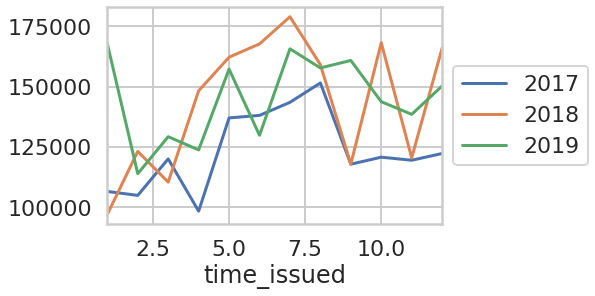

In [52]:
(time_df.groupby([time_df['time_issued'].dt.month,\
                       time_df['time_issued'].dt.year])\
 ['Fine_Amount'].count()).unstack().plot(kind='line')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

Text(0, 0.5, 'Total Fine Amount in USD')

findfont: Font family ['calibri'] not found. Falling back to DejaVu Sans.


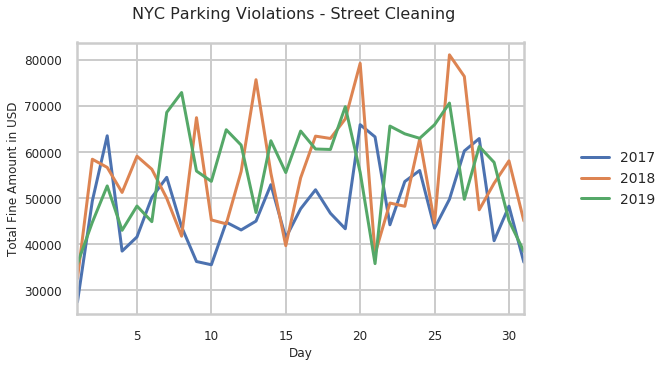

In [53]:
(time_df.groupby([time_df['time_issued'].dt.day,\
                       time_df['time_issued'].dt.year])\
 ['Fine_Amount'].count()).unstack().plot(kind='line', figsize=(8,5))

plt.legend(loc='center left', bbox_to_anchor=(1.1, .5), fontsize='xx-small', frameon=False)
plt.suptitle('NYC Parking Violations - Street Cleaning', fontsize=16)
plt.tick_params(labelsize = 12)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Total Fine Amount in USD', fontsize=12)

Text(0, 0.5, 'Total Fine Amount in USD')

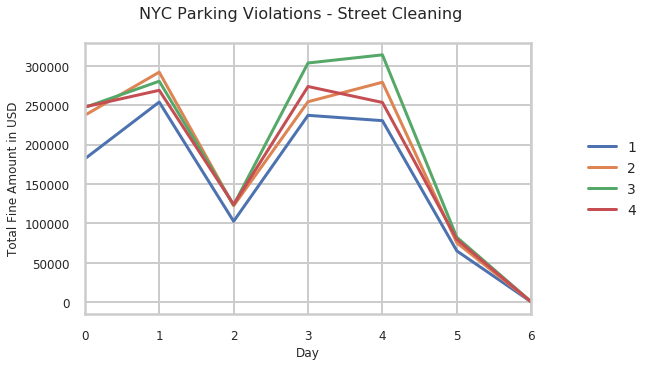

In [54]:
(time_df.groupby([time_df['time_issued'].dt.weekday,\
                       time_df['time_issued'].dt.quarter])\
 ['Fine_Amount'].count()).unstack().plot(kind='line', figsize=(8,5))

plt.legend(loc='center left', bbox_to_anchor=(1.1, .5), fontsize='xx-small', frameon=False)
plt.suptitle('NYC Parking Violations - Street Cleaning', fontsize=16)
plt.tick_params(labelsize = 12)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Total Fine Amount in USD', fontsize=12)

Text(0, 0.5, 'Total Fine Amount in USD')

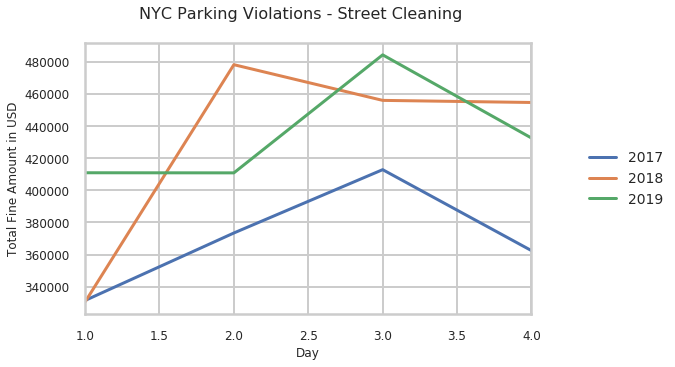

In [55]:
(time_df.groupby([time_df['time_issued'].dt.quarter,\
                       time_df['time_issued'].dt.year])\
 ['Fine_Amount'].count()).unstack().plot(kind='line', figsize=(8,5))

plt.legend(loc='center left', bbox_to_anchor=(1.1, .5), fontsize='xx-small', frameon=False)
plt.suptitle('NYC Parking Violations - Street Cleaning', fontsize=16)
plt.tick_params(labelsize = 12)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Total Fine Amount in USD', fontsize=12)

# Weather Data

Summary

In [56]:
time_df.reset_index(drop=True, inplace=True)

bysum=time_df.groupby(["time_issued"]).agg({'Fine_Amount':'sum','Amount_Due':'sum', 'Payment_Amount':'sum'})
bysum.head()

def form_m(x):
        return "${:.1f}m".format(x/1000000)
    
    
fine_total = bysum.Fine_Amount.sum(axis=0)
due_total= bysum.Amount_Due.sum(axis=0)
payment_total = bysum.Payment_Amount.sum(axis=0)

print("Summary")
print("Total Fines: ",form_m(fine_total))
print("Total Amount Due: ",form_m(due_total))
print("Total Payment Amount: ",form_m(payment_total))

Summary
Total Fines:  $232.4m
Total Amount Due:  $48.2m
Total Payment Amount:  $48.2m


Date

In [57]:
# precinct_dummies = pd.get_dummies(time_df['precinct'], prefix='precinct')
# time_df = pd.concat([time_df, precinct_dummies], axis=1)
# time_df.head()

In [58]:
bydate=time_df.groupby(["time_issued"]).agg({'Fine_Amount':'count',\
                                            'weekday_0':'sum','weekday_1':'sum','weekday_2':'sum',\
                                           'weekday_3':'sum','weekday_4':'sum','weekday_5':'sum','weekday_6':'sum',\
                                            'Manhattan':'sum','Brooklyn':'sum','Bronx':'sum','Queens':'sum'})
bydate=bydate.asfreq('B')
bydate.head()

,Fine_Amount,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,Manhattan,Brooklyn,Bronx,Queens
time_issued,,,,,,,,,,,,
2017-01-02,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2017-01-03,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0
2017-01-04,28.0,0.0,0.0,28.0,0.0,0.0,0.0,0.0,11.0,10.0,2.0,5.0
2017-01-05,52.0,0.0,0.0,0.0,52.0,0.0,0.0,0.0,10.0,22.0,15.0,5.0
2017-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
weather_raw_data = pd.read_csv('CLEAN_weather_200416.csv')
weather = weather_raw_data.copy()

In [60]:
weather['time_issued']=pd.to_datetime(weather['time_issued'], yearfirst=True, errors='coerce')

In [61]:
weather=weather.groupby(["time_issued"])\
.agg({'Precipitation':'mean', \
      'Temperature':'mean', 'Wind':'mean'})

weather= weather.asfreq('B')
weather.head()

,Precipitation,Temperature,Wind
time_issued,,,
2017-01-02,0.001667,34.625000,5.956522
2017-01-03,0.013333,38.923077,11.410256
2017-01-04,0.025135,41.947368,8.245283
2017-01-05,0.000000,30.080000,10.052632
2017-01-06,0.003714,26.000000,4.696970


In [62]:
weather_fine = pd.merge(bydate,weather,how='left',on='time_issued')

print('weather:',weather.shape)
print('   fine:',bydate.shape)
print(' weather_fine:',weather_fine.shape)

weather: (783, 3)
   fine: (782, 12)
 weather_fine: (782, 15)


In [63]:
weather_fine.isna().sum()

Fine_Amount      125
weekday_0        125
weekday_1        125
weekday_2        125
weekday_3        125
weekday_4        125
weekday_5        125
weekday_6        125
Manhattan        125
Brooklyn         125
Bronx            125
Queens           125
Precipitation      0
Temperature        0
Wind             108
dtype: int64

In [64]:
weather_fine=weather_fine.fillna(method='pad')

## Correlation

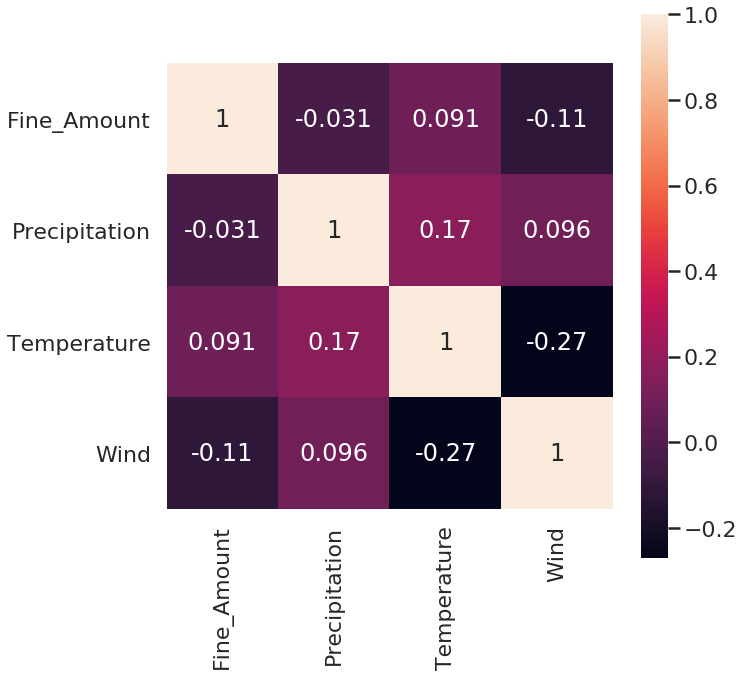

In [65]:
# sns.heatmap

corrmat = weather_fine[['Fine_Amount',\
              'Precipitation', 'Temperature', 'Wind'\
             ]].corr()
fig,ax= plt.subplots()
fig.set_size_inches(10,10)
sns.heatmap(corrmat,square=True,annot=True)

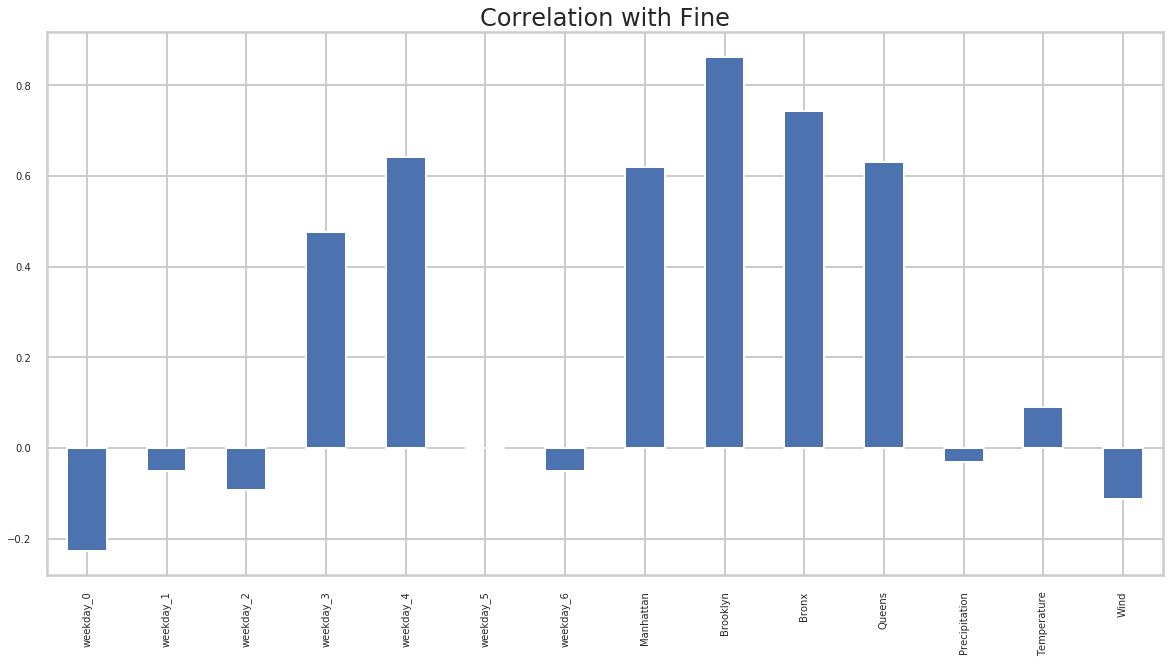

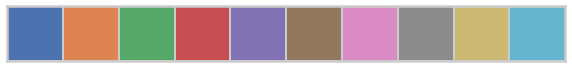

In [66]:
X_weather_fine = weather_fine.drop(['Fine_Amount'],axis=1)
y_weather_fine = weather_fine['Fine_Amount']

sns.set(style="whitegrid", palette=("deep"),font='calibri')
sns.set_context("poster")

X_weather_fine.corrwith(weather_fine['Fine_Amount']).plot.bar(figsize = (20, 10), title ="Correlation with Fine", fontsize = 10,
rot = 90, grid = True,)

sns.palplot(sns.color_palette())

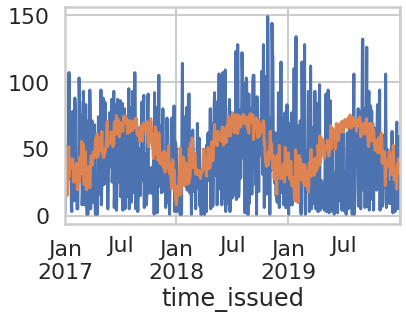

In [67]:
weather_fine.Fine_Amount.plot()
weather_fine.Temperature.plot()

# Models

## Train Test Split

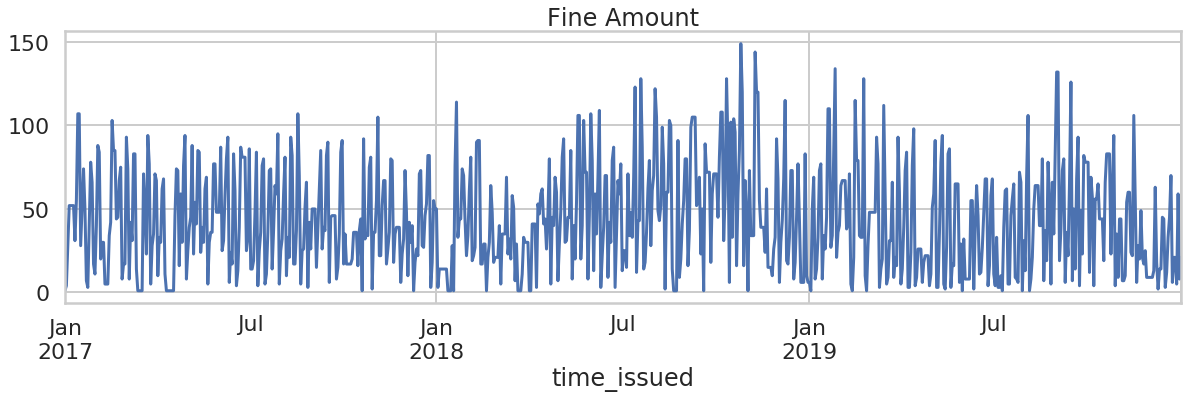

In [68]:
weather_fine.Fine_Amount.plot(figsize = (20,5))
plt.title("Fine Amount", size= 24)
plt.show()

In [70]:
weather_fine.head(5)

,Fine_Amount,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,Manhattan,Brooklyn,Bronx,Queens,Precipitation,Temperature,Wind
time_issued,,,,,,,,,,,,,,,
2017-01-02,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.001667,34.625000,5.956522
2017-01-03,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.013333,38.923077,11.410256
2017-01-04,28.0,0.0,0.0,28.0,0.0,0.0,0.0,0.0,11.0,10.0,2.0,5.0,0.025135,41.947368,8.245283
2017-01-05,52.0,0.0,0.0,0.0,52.0,0.0,0.0,0.0,10.0,22.0,15.0,5.0,0.000000,30.080000,10.052632
2017-01-06,52.0,0.0,0.0,0.0,52.0,0.0,0.0,0.0,10.0,22.0,15.0,5.0,0.003714,26.000000,4.696970


In [71]:
size = int(len(weather_fine)*0.8)

In [72]:
df_train, df_test = weather_fine.iloc[:size], weather_fine.iloc[size:]

In [73]:
zero_dict = {np.nan: 0}
weather_fine.replace(zero_dict, inplace = True)
weather_fine.dropna(inplace = True)

weather_fine.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 782 entries, 2017-01-02 to 2019-12-31
Data columns (total 15 columns):
Fine_Amount      782 non-null float64
weekday_0        782 non-null float64
weekday_1        782 non-null float64
weekday_2        782 non-null float64
weekday_3        782 non-null float64
weekday_4        782 non-null float64
weekday_5        782 non-null float64
weekday_6        782 non-null float64
Manhattan        782 non-null float64
Brooklyn         782 non-null float64
Bronx            782 non-null float64
Queens           782 non-null float64
Precipitation    782 non-null float64
Temperature      782 non-null float64
Wind             782 non-null float64
dtypes: float64(15)
memory usage: 97.8 KB


In [74]:
weather_fine.columns

Index(['Fine_Amount', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6', 'Manhattan', 'Brooklyn', 'Bronx',
       'Queens', 'Precipitation', 'Temperature', 'Wind'],
      dtype='object')

### dickey-fuller test

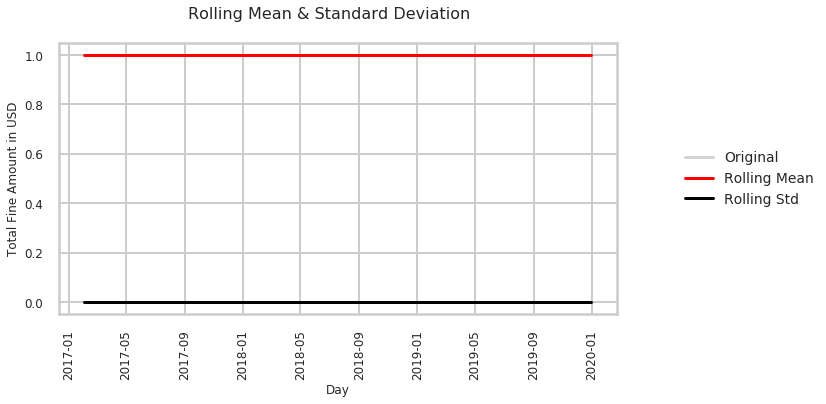

Results of Dickey-Fuller Test:
Test Statistic                        NaN
p-value                               NaN
#Lags Used                       0.000000
Number of Observations Used    781.000000
Critical Value (1%)             -3.438751
Critical Value (5%)             -2.865248
Critical Value (10%)            -2.568744
dtype: float64


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:889: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


In [75]:
def test_stationarity(timeseries, window):
    
#Determine rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(10, 5),)
    orig = plt.plot(timeseries.iloc[window:], color='lightgrey',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc=1, fontsize='x-small', )
    plt.xticks(rotation=90)
    plt.legend(loc='center left', bbox_to_anchor=(1.1,.5), fontsize='xx-small', frameon=False)
    plt.suptitle('Rolling Mean & Standard Deviation', fontsize=16)
    plt.tick_params(labelsize = 12)
    plt.xlabel('Day', fontsize=12)
    plt.ylabel('Total Fine Amount in USD', fontsize=12)
    plt.show()

# Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

letslook = weather_fine.groupby('time_issued')['Fine_Amount'].count()
test_stationarity(letslook, 24)

In [76]:
sts.adfuller(df_train.Fine_Amount) # dickey-fuller test to check for staionarity 

(-3.5985073782164463,
 0.005789627676135943,
 19,
 605,
 {'1%': -3.441204979288887, '5%': -2.86632910370007, '10%': -2.56932048425654},
 5655.74032495872)

In [77]:
log_series = df_train.Fine_Amount.apply(lambda x: np.log(x))  
sts.adfuller(log_series)

(-4.4034427455693725,
 0.00029269588887924033,
 19,
 605,
 {'1%': -3.441204979288887, '5%': -2.86632910370007, '10%': -2.56932048425654},
 1741.6434111487977)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: the 'freq' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/seasonal.py:304: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout()


<Figure size 432x288 with 0 Axes>

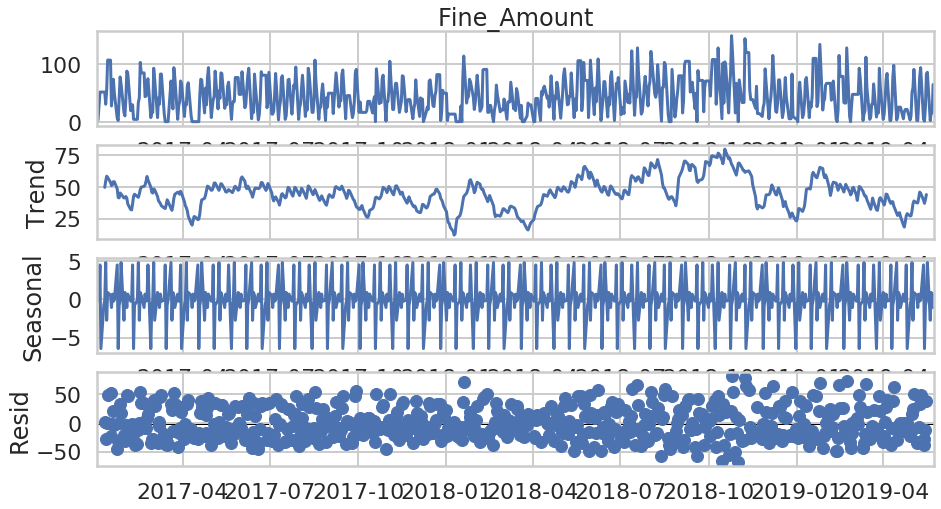

In [78]:
decomposition = seasonal_decompose(df_train.Fine_Amount, freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: the 'freq' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.


<Figure size 432x288 with 0 Axes>

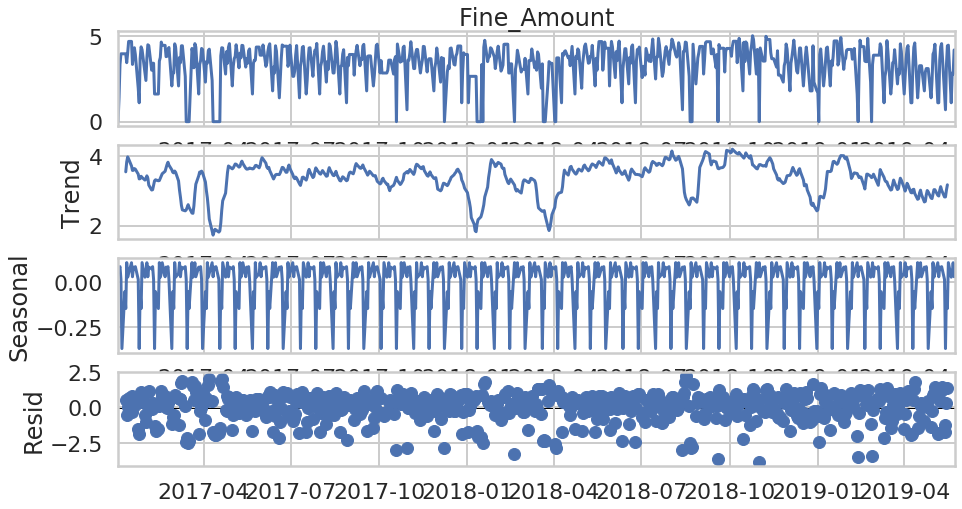

In [79]:
decomposition = seasonal_decompose(log_series, freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

### AR Model

In [80]:
model_ar=ARIMA(df_train["Fine_Amount"],(5,1,0))
model_ar_fit=model_ar.fit()

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)


In [81]:
# prediction_ar= model_ar_fit.forecast(len(df_test))[0]
# y_pred["AR Model Prediction"]=list(np.exp(prediction_ar))
# y_pred

In [82]:
# plt.figure(figsize=(10,5))
# plt.plot(df_train.index,df_train["Fine_Amount"],label="Train Set")
# plt.plot(df_test.index,df_test["Fine_Amount"],label="Test Set")
# plt.plot(y_pred["AR Model Prediction"],label="AR Model Prediction set")
# plt.legend()
# plt.xlabel("Date")
# plt.ylabel('Confirmed Cases')
# plt.title('AR Model: Confirmed')
# plt.xticks(rotation=90)

In [83]:
# AR_model_new_prediction_death=[]
# for i in range(1,18):
#     AR_model_new_prediction_d.append(np.exp(results_ar_death.forecast(len(df_test)+i)[0][-1]))
# model_predictions["AR Model Prediction_death"]=AR_model_new_prediction_death

In [84]:
# model_predictions=pd.DataFrame(zip(new_date),columns=["Dates"])

In [85]:
# new_date=[]
# AR_model_new_prediction=[]
# for i in range(1,18):
#     new_date.append(bydate.index[-1]+timedelta(days=i))
#     AR_model_new_prediction.append(np.exp(model_ar_fit.forecast(len(df_test)+i)[0][-1]))

In [86]:
# model_predictions["AR Model Prediction"]=AR_model_new_prediction

In [87]:
# model_predictions

### MA Model

In [88]:
# model_ma=ARIMA(df_train["Fine_Amount"],(0,1,5))
# model_ma_fit=model_ma.fit()

In [89]:
# prediction_ma= model_ma_fit.forecast(len(df_test))[0]
# y_pred["MA Model Prediction"]=list(np.exp(prediction_ma))

In [90]:
# plt.figure(figsize=(10,5))
# plt.plot(df_train.index,df_train.Fine_Amount,label="Train Set")
# plt.plot(df_test.index,df_test.Fine_Amount,label="Test Set")
# plt.plot(y_pred["MA Model Prediction"],label="MA Prediction Set")
# plt.legend()
# plt.xlabel("Date")
# plt.ylabel('Confirmed Cases')
# plt.xticks(rotation=90)

In [91]:
# MA_model_new_prediction=[]
# for i in range(1,18):
#     MA_model_new_prediction.append(np.exp(model_ma_fit.forecast(len(df_test)+i)[0][-1]))
# model_predictions["MA Model Prediction"]=MA_model_new_prediction

### SARIMA

In [92]:
from pmdarima import auto_arima  

In [93]:
auto_arima(weather_fine['Fine_Amount'],seasonal=True,m=12).summary()

# SARIMAX(2, 0, 3)x(1, 0, [], 12)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Max

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  782
Model:             SARIMAX(2, 0, 3)x(1, 0, [], 12)   Log Likelihood               -3673.738
Date:                             Thu, 16 Apr 2020   AIC                           7363.475
Time:                                     15:43:44   BIC                           7400.770
Sample:                                          0   HQIC                          7377.818
                                             - 782                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     51.8494      4.018     12.903      0.000      43.973      59.725
ar.L1          0.6187      0.001    686.231      0.000       0.617       0.620
ar.L2         -1.0000      0.000  -3528.101      0.000      -1.001      -0.999
ma.L1         -0.4146      0.241     -1.717      0.086      -0.888       0.059
ma.L2          0.8705      0.714      1.220      0.222      -0.528       2.269
ma.L3          0.2079      0.162      1.285      0.199      -0.109       0.525
ar.S.L12       0.1288      0.047      2.731      0.006       0.036       0.221
sigma2       892.2384    681.833      1.309      0.191    -444.130    2228.607
===================================================================================
Ljung-Box (Q):                      314.82   Jarque-Bera (JB):                10.57
Prob(Q):                              0.00   Prob(JB):                         0.01
Heteroskedasticity (H):               1.30   Skew:                             0.28
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [94]:
model = SARIMAX(df_train['Fine_Amount'],order=(2,0,3),seasonal_order=(1,0,1,12))
results = model.fit()
results.summary()

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                          Fine_Amount   No. Observations:                  625
Model:             SARIMAX(2, 0, 3)x(1, 0, [1], 12)   Log Likelihood               -3016.769
Date:                              Thu, 16 Apr 2020   AIC                           6049.537
Time:                                      15:43:46   BIC                           6085.039
Sample:                                  01-02-2017   HQIC                          6063.332
                                       - 05-24-2019                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2542      0.327      0.778      0.436      -0.386       0.894
ar.L2          0.7449      0.326      2.285      0.022       0.106       1.384
ma.L1          0.0861      0.331      0.260      0.795      -0.562       0.735
ma.L2         -0.8213      0.199     -4.127      0.000      -1.211      -0.431
ma.L3         -0.2002      0.128     -1.563      0.118      -0.451       0.051
ar.S.L12       0.9753      0.762      1.279      0.201      -0.519       2.469
ma.S.L12      -0.9770      0.747     -1.307      0.191      -2.442       0.488
sigma2       906.6345     62.493     14.508      0.000     784.150    1029.119
===================================================================================
Ljung-Box (Q):                      961.30   Jarque-Bera (JB):                12.02
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.50   Skew:                             0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [95]:
start=len(df_train)
end=len(df_train)+len(df_test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(0,1,0)(2,0,0,12) Predictions')

No handles with labels found to put in legend.


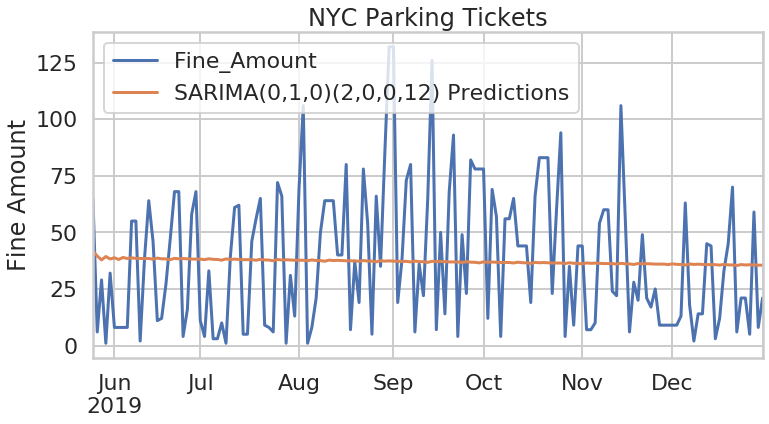

In [96]:
title='NYC Parking Tickets'
ylabel='Fine Amount'
xlabel=''

ax.legend(loc='center left', bbox_to_anchor=(1.1, .5), fontsize='xx-small', frameon=False)

ax = df_test['Fine_Amount'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [97]:
error1 = mean_squared_error(df_test['Fine_Amount'], predictions)
error2 = rmse(df_test['Fine_Amount'], predictions)
print(f'SARIMA(0,1,0)(2,0,0,12) MSE Error: {error1:11.10}')
print(f'SARIMA(0,1,0)(2,0,0,12) RMSE Error: {error2:11.10}')

SARIMA(0,1,0)(2,0,0,12) MSE Error: 909.7693312
SARIMA(0,1,0)(2,0,0,12) RMSE Error: 30.16238272


In [98]:
model = SARIMAX(df_test['Fine_Amount'],order=(3,1,3),seasonal_order=(1,0,1,12))
results = model.fit()
fcast = results.predict(len(df_test),len(df_test)+11,typ='levels').rename('SARIMA(3,1,3)(1,0,1,12) Forecast')
# (3,1,3),seasonal_order=(1,0,1,12))

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Text(0, 0.5, 'Total Fine Amount in USD')

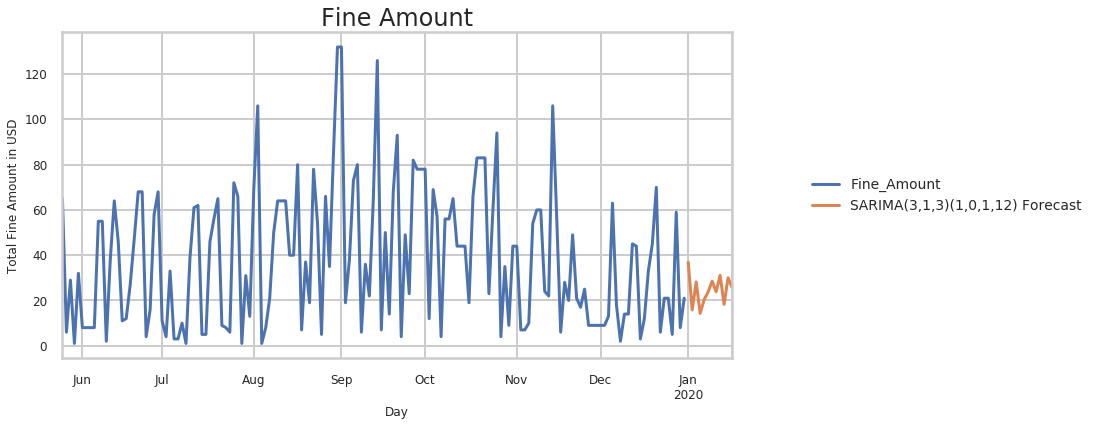

In [99]:
title='Fine Amount'


ax = df_test['Fine_Amount'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
plt.legend(loc='center left', bbox_to_anchor=(1.1, .5), fontsize='xx-small', frameon=False)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

plt.tick_params(labelsize = 12)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Total Fine Amount in USD', fontsize=12)

### XGBoost

In [100]:
xgb_df = weather_fine.copy()

In [101]:
xgb_df.columns

Index(['Fine_Amount', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6', 'Manhattan', 'Brooklyn', 'Bronx',
       'Queens', 'Precipitation', 'Temperature', 'Wind'],
      dtype='object')

In [102]:
X = xgb_df.drop(['Fine_Amount'],axis=1)
y = xgb_df['Fine_Amount']
feature_cols = X.columns

findfont: Font family ['calibri'] not found. Falling back to DejaVu Sans.


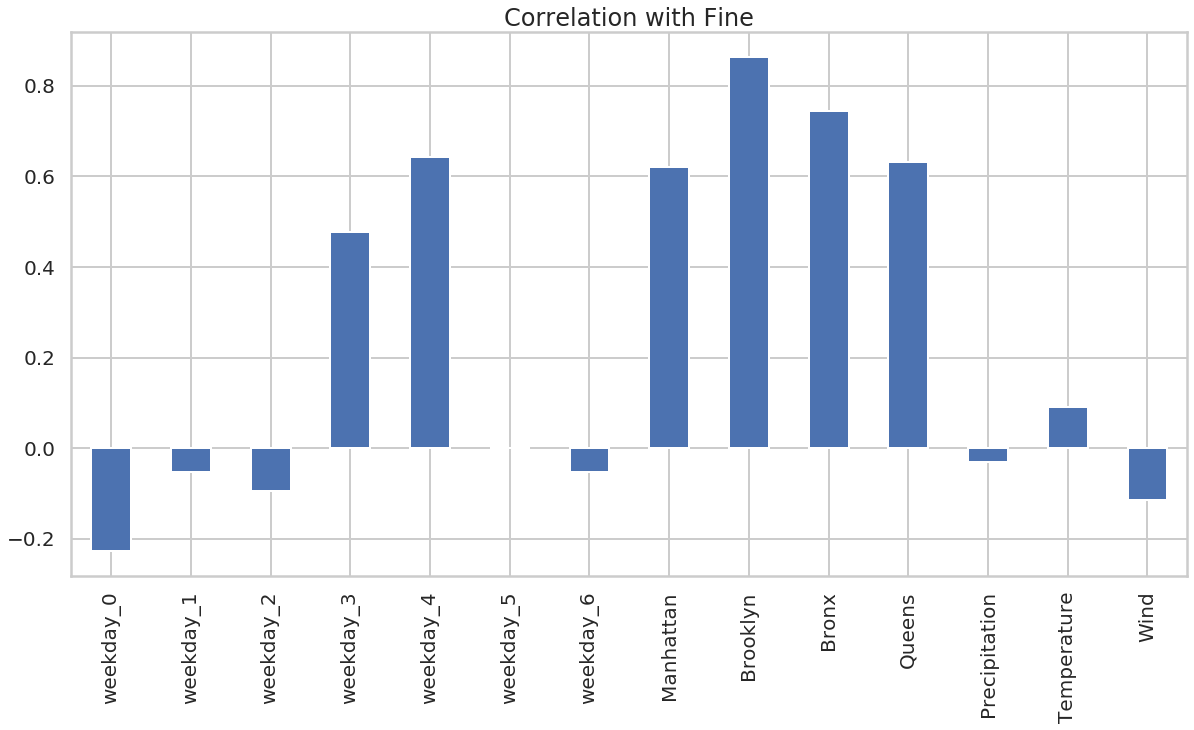

In [103]:
X.corrwith(xgb_df['Fine_Amount']).plot.bar(
        figsize = (20, 10), title = "Correlation with Fine", fontsize = 20,
        rot = 90, grid = True)

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=23)

In [105]:
training = pd.concat([X_train,y_train], axis =1)

In [106]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
import xgboost as xgb
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, roc_auc_score
from sklearn.dummy import DummyClassifier
from sklearn.utils import resample

In [107]:
# # UPSAMPLING

# nprecinct_114 = training[training['precinct_114.0']==0]
# precinct_114 = training[training['precinct_114.0']>=1]

In [108]:
# upsampled = resample(precinct_114,
#                           replace=True, # sample with replacement
#                           n_samples=len(nprecinct_114), # match number in majority class
#                           random_state=23) # reproducible results

# upsampled = pd.concat([nprecinct_114, upsampled])
# upsampled['precinct.114'].value_counts()

In [109]:
# X_train = upsampled.drop('nprecinct_114', axis = 1)
# y_train = upsampled['nprecinct_114']
# feature_cols = X_train.columns
# Line

# # upsampled

In [110]:
X_train.columns

Index(['weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6', 'Manhattan', 'Brooklyn', 'Bronx', 'Queens',
       'Precipitation', 'Temperature', 'Wind'],
      dtype='object')

In [116]:
xgb.XGBClassifier()
xg_clf = xgb.XGBClassifier(objective ='reg:logistic', 
                           colsample_bytree = 0.3, 
                           subsample = 0.5,
                           learning_rate = 0.3,
                           max_depth = 3, 
                           alpha = 1, 
                           n_estimators = 1000)
xg_clf.fit(X_train,y_train)
preds = xg_clf.predict(X_test)

test_f1 = f1_score(y_test, preds,average='weighted')
test_acc = accuracy_score(y_test, preds)

print("Accuracy: %f" % (test_acc))
print("F1: %f" % (test_f1))

Accuracy: 0.321429
F1: 0.312758


DO NOT DELETE!! Uncomment for future use

In [112]:
# precinct_dummies = pd.get_dummies(time_df['precinct'], prefix='precinct')
# time_df = pd.concat([prec_df, precinct_dummies], axis=1)
# #Line
# size = int(len(time_df)*0.8)
# time_df_train, time_df_test = time_df.iloc[:size], time_df.iloc[size:]
# y_pred = time_df_test.copy()
# #Line

# log_series=np.log(df_train["Fine_Amount"])
# #Line

# xgb_df = time_df.copy()
# #Line

# xgb_df.columns
# #Line

# xgb_df.drop(['Unnamed: 0', 'Plate', 'time_issued', 'Amount_Due',
#        'Payment_Amount', 'Bronx', 'Brooklyn', 'Manhattan',
#        'Queens', 'Staten_Island', 'weekday_2'\
#     ], axis=1, inplace=True)
# #Line

# X = xgb_df.drop(['state_0'],axis=1)
# y = xgb_df['state_0']

# X.corrwith(xgb_df3['state_0']).plot.bar(
#         figsize = (20, 10), title = "Correlation with Precinct93", fontsize = 20,
#         rot = 90, grid = True)
# #Line

# X = xgb_df.drop('precinct', axis = 1)
# y = xgb_df['precinct']
# feature_cols = X.columns
# #Line

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=23)
# #Line

# training = pd.concat([X_train,y_train], axis =1)
# #Line

# # UPSAMPLING

# # nweekday_2 = training[training['weekday_2']==0]
# # weekday_2 = training[training['weekday_2']==1]
# #Line
# # from sklearn.dummy import DummyClassifier
# # from sklearn.metrics import accuracy_score, f1_score
# # from sklearn.utils import resample

# # upsampled = resample(nweekday_2,
# #                           replace=True, # sample with replacement
# #                           n_samples=len(nweekday_2), # match number in majority class
# #                           random_state=23) # reproducible results

# # upsampled = pd.concat([nweekday_2, upsampled])
# # upsampled['weekday_2'].value_counts()
# #Line

# # X_train = upsampled.drop('nweekday_2', axis = 1)
# # y_train = upsampled['nweekday_2']
# # feature_cols = X_train.columns
# #Line

# # upsampled
# #Line

# X_train.columns
# #Line

# from xgboost import XGBClassifier
# from sklearn.metrics import f1_score
# import xgboost as xgb
# from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, roc_auc_score
# #Line

# # xgb.XGBClassifier()
# # xg_clf = xgb.XGBClassifier(objective ='binary:logistic', 
# #                            colsample_bytree = 0.3, 
# #                            subsample = 0.5,
# #                            learning_rate = 0.1,
# #                            max_depth = 4, 
# #                            alpha = 1, 
# #                            n_estimators = 1000)
# # xg_clf.fit(X_train,y_train)
# # preds = xg_clf.predict(X_test)

# # test_f1 = f1_score(y_test, preds)
# # test_acc = accuracy_score(y_test, preds)

# # print("Accuracy: %f" % (test_acc))
# # print("F1: %f" % (test_f1))
# #Line